<a href="https://colab.research.google.com/github/surajbhala/MLOps/blob/main/Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub

In [12]:
from IPython.display import Image

In [2]:
!nvidia-smi


Sat Jun  5 14:35:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2021-06-05 14:35:27--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M   103MB/s    in 1.3s    

2021-06-05 14:35:29 (103 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2021-06-05 14:35:29--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[==============

In [4]:
!mkdir beans

In [5]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/

Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [6]:
!ls beans

test  train  validation


In [7]:
!ls beans/train

angular_leaf_spot  bean_rust  healthy


In [8]:
!find beans -type f | wc -l

1296


In [9]:
!find beans/test -type f | wc -l

128


In [10]:
!find beans/validation -type f | wc -l

133


In [14]:
display(Image('beans/train/healthy/healthy_train.0.png'))

In [15]:
display(Image('beans/train/healthy/healthy_train.15.png'))

In [16]:
batch_size = 128
img_height = 224
img_width = 224

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train', seed = 42, image_size=(img_height, img_width), batch_size=batch_size)
## Read, resize and batch the images

Found 1034 files belonging to 3 classes.


In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test', seed = 42, image_size=(img_height, img_width), batch_size=batch_size)

Found 128 files belonging to 3 classes.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation', seed = 42, image_size=(img_height, img_width), batch_size=batch_size)

Found 133 files belonging to 3 classes.


In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [21]:
classes = train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


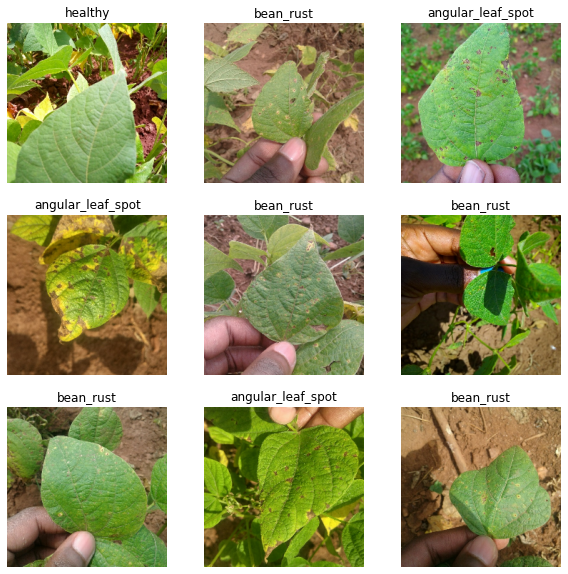

In [26]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[labels[i]])
    plt.axis('off')

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
## prefectch the data based on available memory
##automatically do this depending on memory available
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [28]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [32]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape = (img_height, img_width, 3))

In [33]:
feature_extractor_layer.trainable = False

In [34]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [35]:
tf.random.set_seed(42)

In [36]:
model = tf.keras.Sequential([
                             normalization_layer,
                             feature_extractor_layer,
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(3, activation='softmax')
])

In [37]:
model.compile(optimizer='adam',
              loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [38]:
history = model.fit(train_ds, epochs = 20, validation_data=val_ds)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


9/9 [==============================] - 38s 304ms/step - loss: 1.0828 - accuracy: 0.4884 - val_loss: 0.7674 - val_accuracy: 0.6466
Epoch 2/20
9/9 [==============================] - 1s 145ms/step - loss: 0.7771 - accuracy: 0.6441 - val_loss: 0.5963 - val_accuracy: 0.7444
Epoch 3/20
9/9 [==============================] - 1s 146ms/step - loss: 0.6289 - accuracy: 0.7408 - val_loss: 0.5181 - val_accuracy: 0.7820
Epoch 4/20
9/9 [==============================] - 1s 147ms/step - loss: 0.5503 - accuracy: 0.7660 - val_loss: 0.4770 - val_accuracy: 0.7970
Epoch 5/20
9/9 [==============================] - 1s 146ms/step - loss: 0.4957 - accuracy: 0.8027 - val_loss: 0.4322 - val_accuracy: 0.8120
Epoch 6/20
9/9 [==============================] - 1s 145ms/step - loss: 0.4546 - accuracy: 0.8191 - val_loss: 0.4029 - val_accuracy: 0.8346
Epoch 7/20
9/9 [==============================] - 1s 146ms/step - loss: 0.4075 - accuracy: 0.8337 - val_loss: 0.3804 - val_accuracy: 0.8571
Epoch 8/20
9/9 [==============

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


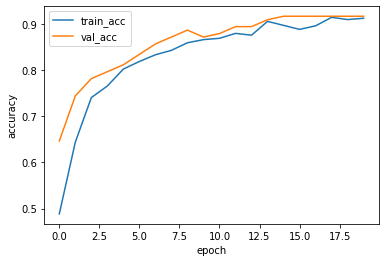

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc','val_acc'],loc = 'best')
plt.show()

In [41]:
result = model.evaluate(test_ds)

1/1 [==============================] - 0s 465ms/step - loss: 0.2900 - accuracy: 0.8828


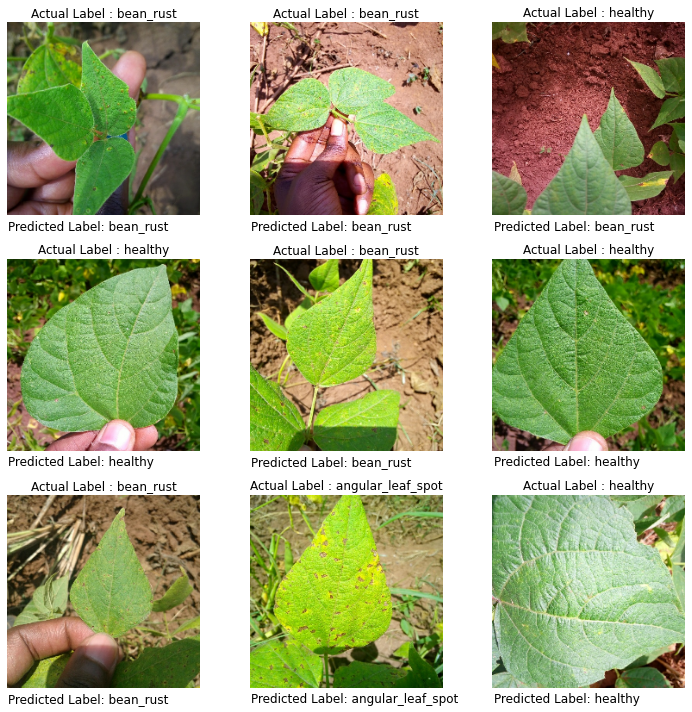

In [42]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)

    plt.tight_layout()

    img = tf.keras.preprocessing.image.img_to_array(images[i])
    img = np.expand_dims(img, axis = 0)

    pred = model.predict(img)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Actual Label : %s" % classes[labels[i]])
    plt.text(1,240, "Predicted Label: %s" % classes[np.argmax(pred)], fontsize = 12)
    plt.axis("off")

In [44]:
model.save('./models', save_format = 'tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [47]:
!ls -alrt models

total 2060
drwxr-xr-x 1 root root    4096 Jun  5 15:05 ..
drwxr-xr-x 2 root root    4096 Jun  5 15:05 variables
drwxr-xr-x 2 root root    4096 Jun  5 15:05 assets
-rw-r--r-- 1 root root 2081784 Jun  5 15:05 saved_model.pb
-rw-r--r-- 1 root root    6625 Jun  5 15:05 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Jun  5 15:05 .


In [46]:
model_loaded = tf.keras.models.load_model('./models/')

In [48]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [49]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
  np_image = Image.open(filename)
  np_image = np.array(np_image).astype('float32')
  np_image = transform.resize(np_image, (224,224,3))
  np_image = np.expand_dims(np_image, axis = 0)
  return np_image

In [51]:
pred_label = model_loaded.predict(process('beans/train/healthy/healthy_train.0.jpg'))

In [52]:
print(classes[np.argmax(pred_label)])

healthy


In [53]:
pred_label

array([[6.5018644e-04, 3.6428910e-02, 9.6292090e-01]], dtype=float32)

In [54]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/assets/ (stored 0%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/saved_model.pb (deflated 91%)
  adding: models/keras_metadata.pb (deflated 81%)


In [55]:
print(tf.__version__)

2.5.0
